In [1]:
!pip install networkx

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import networkx as nx

import os
import shutil 
import numpy as np
import pandas as pd
import gc
import json
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from spektral.data import Dataset, Graph, SingleLoader, BatchLoader, DisjointLoader
from spektral.layers import GCNConv
from spektral.layers.convolutional import gcn_conv
from spektral.utils import normalized_adjacency, gcn_filter, degree_matrix
from spektral.models.gcn import GCN 
from spektral.datasets.utils import DATASET_FOLDER

from scipy import sparse
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score

from keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
def plot_graph(G, communities=None):
    pos = nx.spring_layout(G, seed=42)
    
    if communities is not None:
        # Assign colors to nodes based on their communities
        colors = ['orange' if community == 0 else 'skyblue' for community in communities]
    else:
        colors = 'red'

    nx.draw(G, pos, node_color=colors, with_labels=True)
    plt.show()

# Nueva clase para generar grafos sintéticos (siguiendo a Carson)

### Funciones necesarias para definir la clase

In [5]:
def generate_ssbm(num_nodes,num_classes,p_intra,p_inter,community = None):
    """
    Adapted from: https://github.com/brownthesr/Synthetic-Graphs/blob/main/src/generate_data.py#L49
    
    Generates a SSBM.

    This function generates a Symmetric Stochastic Block model. It does
    this by creating blocks for in and out of class probability. Then
    it draws from a uniform distribution and uses the p_intra and p_inter
    probabilities to assign edges between specific nodes

    Args:
        num_nodes (int): The number of nodes.
        num_classes (int): The number of classes.
        p_intra (float): The probability of having
            in class connections.
        p_inter (float): The probability of having
            edges between classes
        community (list): Optional, may specify how
            the nodes are divided into communities.
            Automatically assigns communities if none
            are provided.

    Returns:
        Graph (list): An adjacency matrix representing the
            edges in the generated graph.
        Communities (list): The node assignment to communities.
    """
    #### TATI: podriamos pasarle como argumento las clases desbalanceadas ####
    if community is None: 
         #### TATI: esto genera clases balanceadas ####
        # assign a community to each node
        community = np.repeat(list(range(num_classes)),np.ceil(num_nodes/num_classes))
        
        #### TATI: le agrego shuffle para que se mezclen los nodos y no queden primero todos los de clase 0,
        ####       y luego todos los de clase 1 (lo comento para que quede como estaba originalmente)
        #np.random.shuffle(community) 
        #np.repeat(list to iterate over, how many times to repeat an item)

        #make sure community has size n
        community = community[0:num_nodes]
        # just in case repeat repeated too many

    communities = community.copy()

    # make it a collumn vector
    community = np.expand_dims(community,1)

    # generate a boolean matrix indicating whether
    # two nodes share a community
    # this is a smart way to generate a section graph
    intra = community == community.T
    inter = community != community.T# we can also use np.logical not

    random = np.random.random((num_nodes,num_nodes))
    tri = np.tri(num_nodes,k=-1).astype(bool)

    #### TATI: cambie "intragraph" por "intergraph", y viceversa #### (lo volvi a cambiar por como estaba originalmente)
    intergraph = (random < p_intra) * intra * tri 
    # this creates a matrix that only has trues where
    # random< p_intra, they are in intra, and along half the matrix
    # (if it were the whole matrix it would be double the edges we want)
    intragraph = (random < p_inter) * inter * tri# same thing here
    graph = np.logical_or(intergraph,intragraph)
    graph = graph*1# this converts it to a int tensor
    #### TATI: atencion: matriz adyacencia simetrica (grafo no dirigido) ####
    graph += graph.T
    return graph,communities

In [6]:
def generate_orthogonal_vecs(num_vecs,num_dim):
    """
    Copied from https://github.com/brownthesr/Synthetic-Graphs/blob/main/src/generate_data.py#L148
    
    Generates Orthogonal vectors

    Uses a random generation process to generate num_vecs
    orthogonal vectors in num_dim dimensions.

    Args:
        num_vecs (int): The number of vectors we want to return.
        num_dim (int): The number of dimensions that we can use.

    Returns:
        vecs (list): A list of randomly orthogonal vectors
    """
    vecs = []
    assert num_vecs <= num_dim
    for i in range(num_vecs):
        orthogonal = False
        while not orthogonal:
            rand_vec = np.random.uniform(-10,10,num_dim)
            rand_vec = rand_vec/np.linalg.norm(rand_vec)
            orthogonal = True
            for j in range(len(vecs)):
                angle = np.arccos(rand_vec@vecs[j])
                if(angle < np.pi/2 - .1 or angle > np.pi/2 + .1):
                    orthogonal = False
        vecs.append(rand_vec)
        #print(len(vecs))
    return np.array(vecs)



In [7]:
def generate_csbm_TATI(avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                       num_classes, community=None, seed=None):
    #### TATI: agrego argumentos community (para poder pasarle valores desbalanceados) y seed (para replicabilidad)
    """
    Adapted from https://github.com/brownthesr/Synthetic-Graphs/blob/main/src/generate_data.py#L148
    
    Creates a Contextual Stochastic Block model

    It takes the avg degree, degree separation, and feature separation
    to generate a SBM with features corrosponding to classes.

    Args:
        avg_degree (int): The average degree of all the nodes.
        degree_separation (float): The separation constrain for edges in classes and edges between classes.
        features_separation (float): A measure of how far apart the means are.
        num_features (int): The number of features to generate.
        num_nodes (int): The number nodes to generate.
        num_classes (int): The number of classes to generate

    Returns:
        Adjacency matrices for a training and testing set.
        Features for training and testing sets.
        Labels for training and testing sets.
    """
    #### TATI: agrego estas dos lineas para tener en cuenta la semilla ####
    if seed is not None:
        np.random.seed(seed)
            
    c_in = avg_degree+edge_separation_lambda*np.sqrt(avg_degree) # c_in/c_out as described in the equations
    c_out = avg_degree-edge_separation_lambda*np.sqrt(avg_degree)
    p_in = c_in/num_nodes # compiles these to pass into the SSBM
    p_out = c_out/num_nodes

    rand_vec = np.random.normal(0,1/num_features,(num_features))
    # obtains the random normal vector u how far our clouds are from the origin

    #### TATI: agrego el argumento community ####
    train_adj, train_communities = generate_ssbm(num_nodes,num_classes,p_in,p_out,community)
    # obtains the graph structure
    train_z = np.random.normal(0,.2,(num_nodes,num_features))
    # obtains the random noise vector i presume
    train_v = train_communities # puts the groups into a format for the equations

    perms = generate_orthogonal_vecs(num_classes,num_features)
    #print(communities)
    #print(perms)
    dist = np.sqrt(feature_separation_mu/num_nodes)
    train_b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        train_b[i] = dist*(np.diag(perms[train_v[i]])@rand_vec) + train_z[i]/np.sqrt(num_features)

    #### TATI: elimino la creacion de grafo test ####
    
    #### TATI: transformo etiquetas y matriz de adyacencia, y retorno segun el formato de spektral ####
    labels = tf.keras.utils.to_categorical(train_communities)
    adjacency_matrix = sparse.csr_matrix(train_adj)
    return Graph(x=train_b, a=adjacency_matrix, y=labels)


In [8]:
def save_parameters(parameters, filename):
    with open(filename, 'w') as f:
        json.dump(parameters, f)
        
def load_parameters(filename):
    with open(filename, 'r') as f:
        return json.load(f)


### Clase (Grafos NO dirigidos)

In [9]:
class Carson_SyntheticGraphs(Dataset): # modificacion 2024 para cacic-springer
    
    def __init__(self, avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed = None, community = None, flattened = False, **kwargs):
        self.avg_degree = avg_degree
        self.edge_separation_lambda = edge_separation_lambda
        self.feature_separation_mu = feature_separation_mu
        self.num_features = num_features
        self.num_nodes = num_nodes
        self.num_classes = num_classes
        self.num_graphs = num_graphs
        self.seed = seed
        self.community = community
        self.flattened = flattened
        super().__init__(**kwargs)

    @property
    def path(self):
        dirname = f'{self.avg_degree}AvgDegree_{self.edge_separation_lambda}Lambda_\
{self.feature_separation_mu}Mu_{self.num_features}Features_{self.num_nodes}Nodes_\
{self.num_classes}Classes_{self.num_graphs}Graphs'

        return os.path.join(DATASET_FOLDER, "Carson_SyntheticGraphs", dirname)
        
        
    # Getter para obtener los argumentos utilizados
    @property
    def get_args(self):
        return {"avg_degree": self.avg_degree, "edge_separation_lambda": self.edge_separation_lambda, \
                "feature_separation_mu": self.feature_separation_mu, "num_features": self.num_features, \
                "num_nodes": self.num_nodes, "num_classes": self.num_classes, "num_graphs": self.num_graphs, \
                "seed": self.seed, "community": self.community, "flattened": self.flattened}

    
    def download(self):
        os.makedirs(self.path)
        
        parameters = self.get_args
        
        if self.seed == None:
            vector_seed = [None] * self.num_graphs
        else:
            vector_seed = self.seed
            
        if self.community == None:
            vector_community = [None] * self.num_graphs
        else:
            vector_community = self.community
            for i in range(len(self.community)):
                parameters["community"][i] = self.community[i].tolist()
                
        graphs = [generate_csbm_TATI(self.avg_degree, self.edge_separation_lambda, self.feature_separation_mu, \
                                     self.num_features, self.num_nodes, self.num_classes, vector_community[i], \
                                     vector_seed[i]) for i in range(self.num_graphs)]
        for j in range(self.num_graphs):
            filename = os.path.join(self.path, f'graph_{j:02d}.npz')
            np.savez(filename, x=graphs[j].x, a=graphs[j].a, y=graphs[j].y)
        
        save_parameters(parameters, os.path.join(self.path,"parameters.json"))
        # Free memory
        del graphs
        gc.collect()

        

    def read(self): 
        if os.path.exists(self.path):
            parameters = load_parameters(os.path.join(self.path,"parameters.json"))
        
        #### TATI: if self.seed==None entonces debería generar nuevos (no leer lo que ya está de antes).
        ####       Lo mismo si cambia alguna semilla, o si cambia la clase a la que pertenece algun nodo ####
        if ((self.seed == None) or 
            (self.seed != None and parameters["seed"] != self.get_args["seed"]) or 
            (self.community != None and (np.array(parameters["community"]) != np.array(self.get_args["community"])).any())):
            self.delete()
            self.download()           

        # We must return a list of Graph objects
        output = []

        for j in range(self.num_graphs):
            data = np.load(os.path.join(self.path, f'graph_{j:02d}.npz'), allow_pickle=True)
            #### if flattened, entonces en lugar de leer las features guardadas, asigna una matriz de todos 1 ####
            if self.flattened:
                x_features = np.ones((self.num_nodes, self.num_features))
            else:
                x_features = data['x']
            output.append(
                Graph(x=x_features, a=data['a'][()], y=data['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    
    def delete(self):
        if os.path.exists(self.path):
            shutil.rmtree(self.path)


# GCN

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


1 Physical GPUs, 1 Logical GPUs


### Funciones para preprocesar la matriz de features

In [11]:
def _preprocess_features(features):
    """
    Copy from https://github.com/danielegrattarola/spektral/blob/39fe897c5c06ce8bd8100e10fe9d373b91958cc7/spektral/datasets/citation.py#L192
    """
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sparse.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features


class GCNConv_preprocess_features(object):
    """
    Applies the `_preprocess_features` to the node features.
    
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, graph):
        graph.x = _preprocess_features(graph.x)
        return graph


### Función para preprocesar la matriz de adyacencia

In [12]:
class GCNConv_preprocess_adjacencyMatrix(object):
    """
    Applies the `gcn_filter` function of a GCN Layer to the adjacency
    matrix. The result depends on symmetry of adjacency matrix.

    **Arguments**

    - `layer_class`: the class of a layer from `spektral.layers.convolutional`,
    in order to verify if it is a GCNConv.
    - `symmetric`: boolean, indicates if adjacency matrix is symmetric (undirected graph),
    or if it is non-symmetric (directed graph).
    """

    def __init__(self, layer_class, symmetric):
        self.layer_class = layer_class
        self.symmetric = symmetric

    def __call__(self, graph):
        if self.layer_class == GCNConv:
            if self.symmetric:
                graph.a = gcn_filter(graph.a)
            else:
                graph.a = gcn_filter(graph.a, symmetric=False)
            return graph
        else:
            raise ValueError('The parameter must be GCNConv. For other convolutional layers, find the appropriate preprocessing')


### Función para cargar los grafos y realizar el/los preprocesamiento/s requerido/s

In [13]:
def instancia(clase, avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flatten=False, symmetricAdjacency=False, \
                 preprocAdjacency=True, preprocFeatures=True):
    """
    Función para instanciar cada una de las clases que definen los diferentes conjuntos de grafos sintéticos
    """
    if preprocAdjacency and preprocFeatures:
        inst = clase(avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flattened=flatten, \
                     transforms=[GCNConv_preprocess_adjacencyMatrix(GCNConv, symmetric=symmetricAdjacency), \
                                 GCNConv_preprocess_features()])
    elif preprocAdjacency and ~preprocFeatures:
        inst = clase(avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flattened=flatten, \
                     transforms=[GCNConv_preprocess_adjacencyMatrix(GCNConv, symmetric=symmetricAdjacency)])
    elif ~preprocAdjacency and preprocFeatures:
        inst = clase(avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flattened=flatten, \
                     transforms=[GCNConv_preprocess_features()])
    else:
        inst = clase(avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flattened=flatten)
    return inst



In [14]:
def log_softmax(x, axis=1):
    # Calcular softmax a lo largo del eje especificado
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    softmax_x = exp_x / np.sum(exp_x, axis=axis, keepdims=True)
    
    # Aplicar logaritmo natural
    log_softmax_x = np.log(softmax_x)
    
    return log_softmax_x

In [15]:
class GCN_TATI(tf.keras.Model):
    """
    This model, with its default hyperparameters, implements the architecture
    from the paper:

    > [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)<br>
    > Thomas N. Kipf and Max Welling

    **Mode**: single, disjoint, mixed, batch.

    **Input**

    - Node features of shape `([batch], n_nodes, n_node_features)`
    - Weighted adjacency matrix of shape `([batch], n_nodes, n_nodes)`

    **Output**

    - Softmax predictions with shape `([batch], n_nodes, n_labels)`.

    **Arguments**

    - `n_labels`: number of channels in output;
    - `channels`: number of channels in first GCNConv layer;
    - `activation`: activation of the first GCNConv layer;
    - `output_activation`: activation of the second GCNConv layer;
    - `use_bias`: whether to add a learnable bias to the two GCNConv layers;
    - `dropout_rate`: `rate` used in `Dropout` layers;
    - `l2_reg`: l2 regularization strength;
    - `**kwargs`: passed to `Model.__init__`.
    """

    def __init__(
        self,
        n_labels,
        channels=16,
        activation="relu",
        output_activation="softmax",
        use_bias=False,
        dropout_rate=0.5,
        #l2_reg=2.5e-4,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_labels = n_labels
        self.channels = channels
        self.activation = activation
        self.output_activation = output_activation
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        #self.l2_reg = l2_reg
        #reg = tf.keras.regularizers.l2(l2_reg)
        #self._d0 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn0 = gcn_conv.GCNConv(
            channels, activation=activation, use_bias=use_bias
            #channels, activation=activation, kernel_regularizer=reg, use_bias=use_bias
        )
        self._d1 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn1 = gcn_conv.GCNConv(
            n_labels, activation=output_activation, use_bias=use_bias
        )


    def get_config(self):
        return dict(
            n_labels=self.n_labels,
            channels=self.channels,
            activation=self.activation,
            output_activation=self.output_activation,
            use_bias=self.use_bias,
            dropout_rate=self.dropout_rate,
            #l2_reg=self.l2_reg,
        )

    def call(self, inputs):
        if len(inputs) == 2:
            x, a = inputs
        else:
            x, a, _ = inputs  # So that the model can be used with DisjointLoader

        #x = self._d0(x)
        x = self._gcn0([x, a])
        x = self._d1(x)
        return self._gcn1([x, a])

### Función para predecir y calcular las métricas

In [16]:
def predicciones(loader, nombre, model):
    """
    Calcula las predicciones y métricas de interés
    """
    TP_list = []
    FN_list = []
    FP_list = []
    TN_list = []
    acc = []
    prec = []
    rec = []
    esp = []
    F1 = []
    auc = []
    
    for k in range(loader.steps_per_epoch):
        inputs,target = loader.__next__()
        y_prediction = model(inputs, training=False)
        y_prediction = np.argmax(np.vstack(y_prediction), axis = 1)
        y_true=np.argmax(np.vstack(target), axis=1)
        prediccion=pd.DataFrame({"true_label":y_true, "prediction":y_prediction})
        #print(prediccion)
        #prediccion.to_csv(os.path.join(prediccionesDirectorio,f'{str(NOMBRE_PRUEBA)}_prediccion_{str(nombre)}_0{k}.csv'),index = None)
        
        #Create confusion matrix and normalizes it over predicted (columns)
        result = tf.math.confusion_matrix(y_true, y_prediction, num_classes=2) 

        # confusion_matrix = [[TP, FN],
        #                     [FP, TN]]
        TP = result[0,0].numpy()
        FN = result[0,1].numpy()
        FP = result[1,0].numpy()
        TN = result[1,1].numpy()

        accuracy = (TP+TN)/(TP+FP+FN+TN)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        especificity = TN/(TN+FP)
        f1 = (2*precision*recall)/(precision+recall)
        auc_score = roc_auc_score(y_true, y_prediction)
        
        TP_list.append(TP)
        FN_list.append(FN)
        FP_list.append(FP)
        TN_list.append(TN)
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        esp.append(especificity)
        F1.append(f1)
        auc.append(auc_score)
        
    df = pd.DataFrame({"TP":TP_list, "FN":FN_list, "FP":FP_list, "TN":TN_list, "accuracy":acc, "precision":prec, "recall":rec, "especificity":esp, "f1":F1, "auc_score":auc})
    #df.to_csv(os.path.join(metricasDirectorio, f'{str(NOMBRE_PRUEBA)}_metricas_{str(nombre)}.csv'), index = None)
    print(df)
    return df


### Función para entrenar y evaluar

In [17]:
def train_and_test_carson(dataset, num_exp):
    aux = {}
    for i in range(num_exp):
        #graficasDirectorio = os.path.join(PATH_RDOS,f'prueba_0{i}/graficas')
        #prediccionesDirectorio = os.path.join(PATH_RDOS,f'prueba_0{i}/predicciones')
        #metricasDirectorio = os.path.join(PATH_RDOS,f'prueba_0{i}/metricas')

        #os.makedirs(graficasDirectorio, exist_ok = True)
        #os.makedirs(prediccionesDirectorio, exist_ok = True)
        #os.makedirs(metricasDirectorio, exist_ok = True)

        tf.keras.backend.clear_session() 

        #indices = np.concatenate((np.arange(i), np.arange(i+1,10)))
        #graphs4train = dataset[indices]
        #test_dataset = dataset[i:i+1]

        #idxs = np.random.permutation(len(graphs4train))
        #split_va = int(0.9 * len(graphs4train))
        #idx_tr, idx_va = np.split(idxs, [split_va])
        #train_dataset = graphs4train[idx_tr]
        #val_dataset = graphs4train[idx_va]

        train_dataset = dataset[i:i+1]
        val_dataset = dataset[i+num_exp:i+num_exp+1]
        test_dataset = dataset[i+2*num_exp:i+2*num_exp+1]
        
        #batch_size = 1
        n_epochs = 400

        # Se crean data loaders
        #train_loader = BatchLoader(train_dataset, batch_size=batch_size, epochs=n_epochs, shuffle=False, node_level=True)   
        train_loader = SingleLoader(train_dataset, epochs=n_epochs)   
        val_loader = SingleLoader(val_dataset, epochs=n_epochs)
        test_loader = SingleLoader(test_dataset, epochs=n_epochs)

        n_classes = 2
        model = GCN_TATI(n_labels=n_classes, channels=16, use_bias=True)

        # Compila el model
        model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])


        # Entrenamiento
        history = model.fit(
            train_loader.load(),
            steps_per_epoch=train_loader.steps_per_epoch,
            epochs=n_epochs,
            validation_data=val_loader.load(),
            validation_steps=val_loader.steps_per_epoch,
            verbose=0
            #callbacks=callbacks_list                            
        )

        ## GRAFICAR
        res = pd.DataFrame(history.history)
        res.reset_index(inplace=True)
        res.rename(columns={'index': 'epoch'}, inplace=True)
        #res.to_csv(os.path.join(graficasDirectorio,f'{str(NOMBRE_PRUEBA)}_epochsResults.csv'),index = None)          

        sns.set_theme(style="whitegrid")
        line1 = sns.lineplot(x="epoch", y='loss', data=res, label='Training Loss')
        line2 = sns.lineplot(x="epoch", y='val_loss', data=res, label='Test Loss')
        scatter1 = sns.scatterplot(x="epoch", y='loss', data=res, marker='o', color='skyblue')
        scatter2 = sns.scatterplot(x="epoch", y='val_loss', data=res, marker='o', color='orange')
        plt.ylabel("Loss Value")
        plt.legend()
        plt.show()
        #plt.savefig(os.path.join(graficasDirectorio,f'{str(NOMBRE_PRUEBA)}_loss.png'))                             
        plt.clf()

        sns.set_theme(style="whitegrid")
        line1 = sns.lineplot(x="epoch", y="accuracy", data=res, label='Training Accuracy')
        line2 = sns.lineplot(x="epoch", y="val_accuracy", data=res, label='Test Accuracy')
        scatter1 = sns.scatterplot(x="epoch", y="accuracy", data=res, marker='o', color='skyblue')
        scatter2 = sns.scatterplot(x="epoch", y="val_accuracy", data=res, marker='o', color='orange')
        plt.ylabel("Accuracy Value")
        plt.legend()
        plt.show()
        #plt.savefig(os.path.join(graficasDirectorio,f'{str(NOMBRE_PRUEBA)}_accuracy.png'))              
        plt.clf()

        # PREDICCION
        #train_loader = BatchLoader(train_dataset, batch_size=batch_size, epochs=n_epochs, shuffle=False, node_level=True)   
        train_loader = SingleLoader(train_dataset, epochs=n_epochs)  
        val_loader = SingleLoader(val_dataset, epochs=n_epochs)
        test_loader = SingleLoader(test_dataset, epochs=n_epochs)
        loaders = [test_loader, val_loader, train_loader]
        names = ["test", "val", "train"]
        aux[i] = {}
        for j in range(len(loaders)):
            print(names[j])
            aux[i][names[j]]=predicciones(loaders[j], names[j], model)
        
    return aux


# Entrenamiento GCN

In [18]:
CLASE = eval("Carson_SyntheticGraphs")

avg_degree=10
edge_separation_lambda=3
feature_separation_mu=0.5
num_features=10
num_nodes=1000
num_classes=2
num_graphs=30
seed=[123, 234, 345, 456, 567, 679, 789, 321, 654, 987, \
      1230, 2340, 3450, 4560, 5670, 6790, 7890, 3210, 6540, 9870, \
      12300, 23400, 34500, 45600, 56700, 67900, 78900, 32100, 65400, 98700
     ]
community = None

FLATTENED = False
SYMMETRIC_ADJACENCY = True
PREPROC_ADJACENCY = True
PREPROC_FEATURES = False

# Se carga el conjunto de grafos
grafos1 = instancia(CLASE, avg_degree, edge_separation_lambda, feature_separation_mu, num_features, num_nodes, \
                 num_classes, num_graphs, seed, community, flatten=FLATTENED, symmetricAdjacency=SYMMETRIC_ADJACENCY,\
                 preprocAdjacency=PREPROC_ADJACENCY, preprocFeatures=PREPROC_FEATURES)



In [ ]:
# for G in grafos1:
#     nxG = nx.from_numpy_array(G.a)
#     labels = np.argmax(G.y,axis=1)
#     plot_graph(nxG,labels)

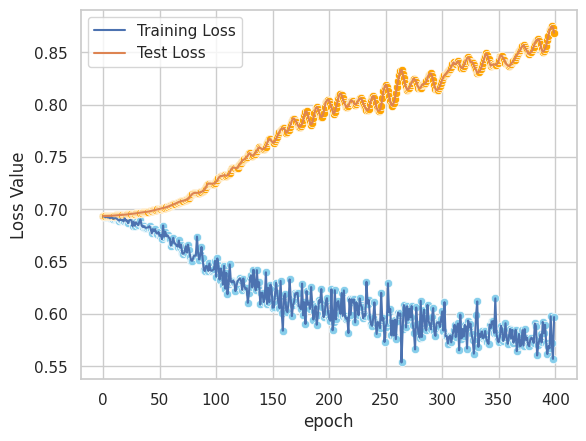

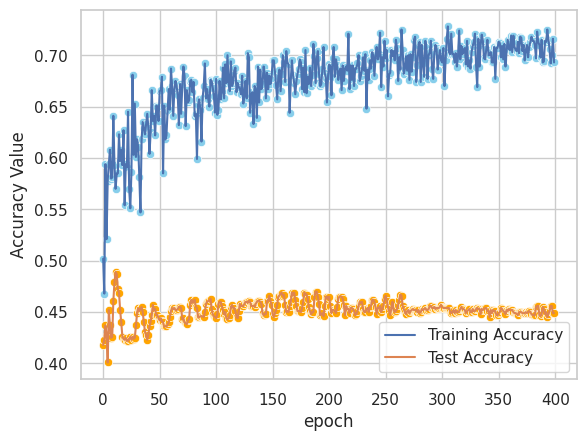

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  105  395  264  236     0.341   0.284553    0.21         0.472  0.241657   

   auc_score  
0      0.341  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  111  389  162  338     0.449   0.406593   0.222         0.676  0.287193   

   auc_score  
0      0.449  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity       f1  \
0  359  141  138  362     0.721   0.722334   0.718         0.724  0.72016   

   auc_score  
0      0.721  


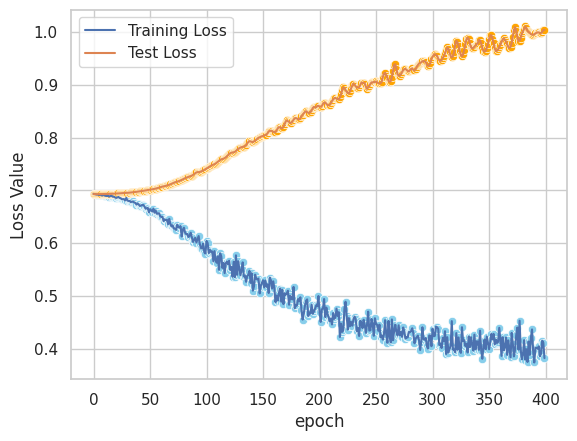

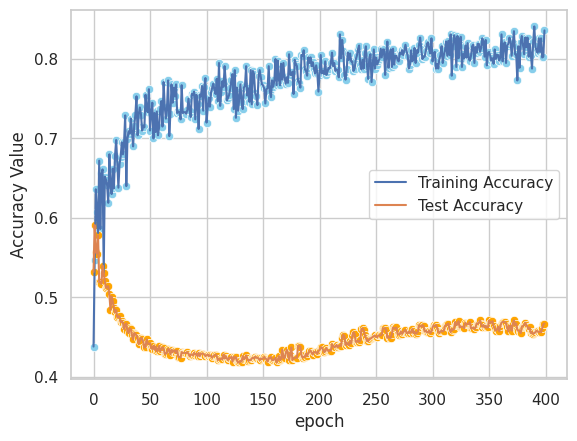

test
    TP   FN   FP  TN  accuracy  precision  recall  especificity        f1  \
0  383  117  417  83     0.466    0.47875   0.766         0.166  0.589231   

   auc_score  
0      0.466  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  326  174  359  141     0.467   0.475912   0.652         0.282  0.550211   

   auc_score  
0      0.467  
train
    TP  FN  FP   TN  accuracy  precision  recall  especificity        f1  \
0  409  91  85  415     0.824   0.827935   0.818          0.83  0.822938   

   auc_score  
0      0.824  


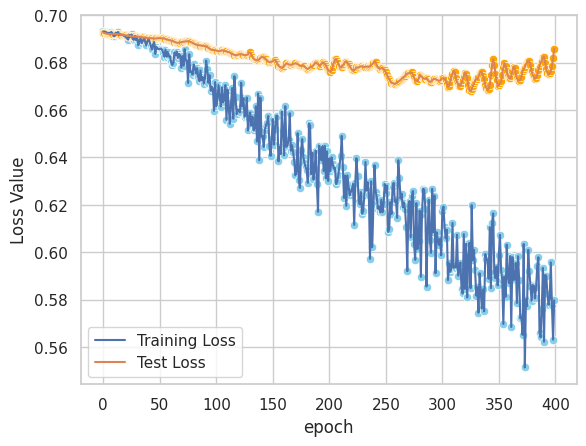

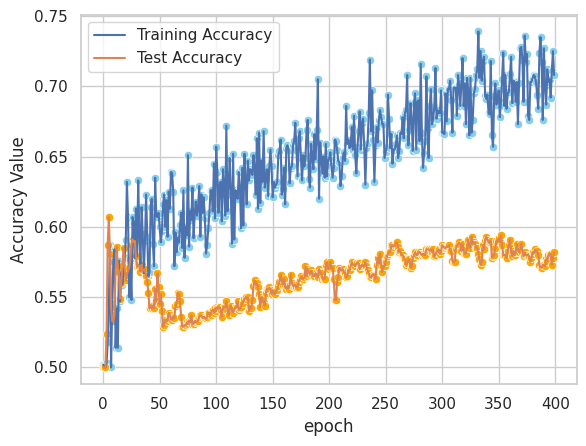

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  225  275  381  119     0.344   0.371287    0.45         0.238  0.406872   

   auc_score  
0      0.344  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  371  129  289  211     0.582   0.562121   0.742         0.422  0.639655   

   auc_score  
0      0.582  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  394  106  153  347     0.741   0.720293   0.788         0.694  0.752627   

   auc_score  
0      0.741  


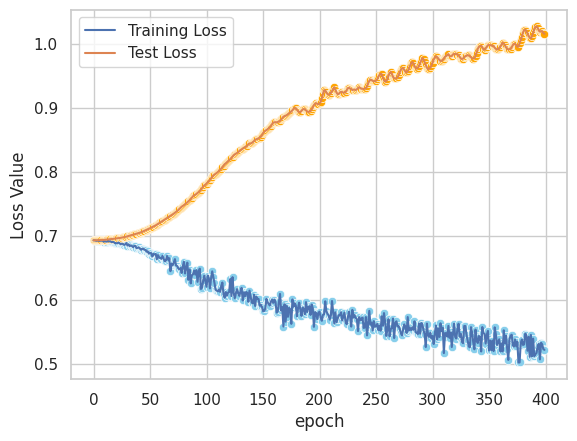

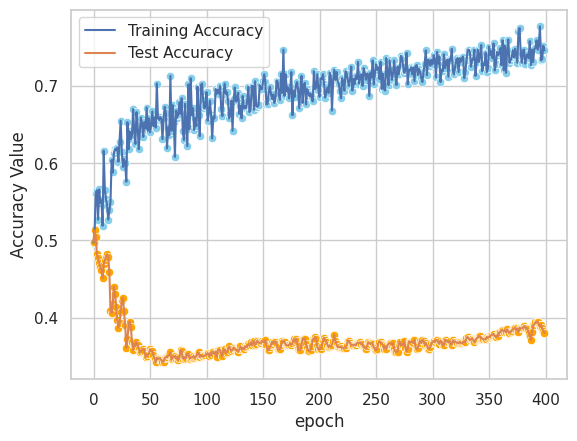

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  280  220  227  273     0.553   0.552268    0.56         0.546  0.556107   

   auc_score  
0      0.553  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  151  349  271  229      0.38    0.35782   0.302         0.458  0.327549   

   auc_score  
0       0.38  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  388  112  139  361     0.749   0.736243   0.776         0.722  0.755599   

   auc_score  
0      0.749  


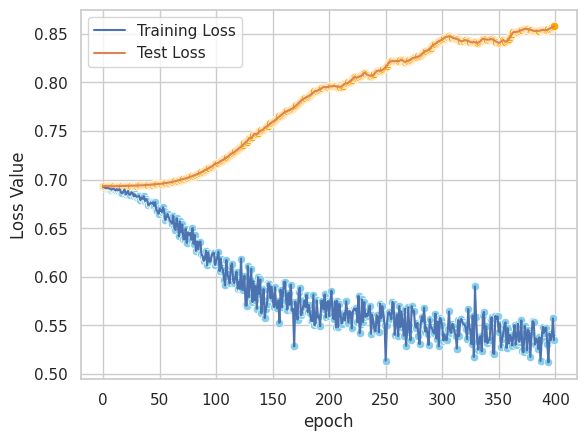

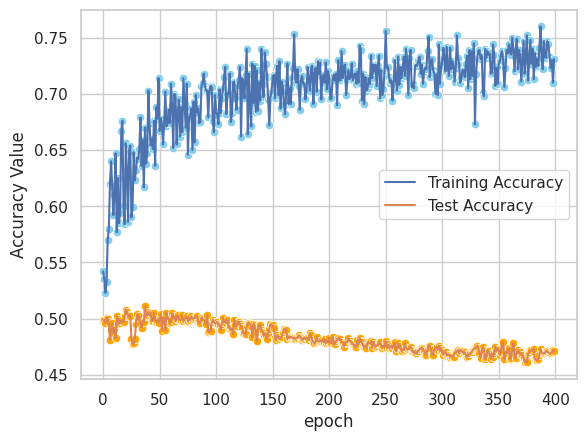

test
   TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  92  408  244  256     0.348    0.27381   0.184         0.512  0.220096   

   auc_score  
0      0.348  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  245  255  274  226     0.471   0.472062    0.49         0.452  0.480864   

   auc_score  
0      0.471  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  367  133  129  371     0.738   0.739919   0.734         0.742  0.736948   

   auc_score  
0      0.738  


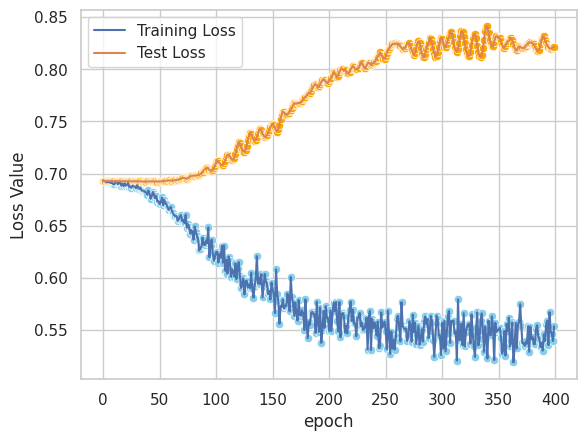

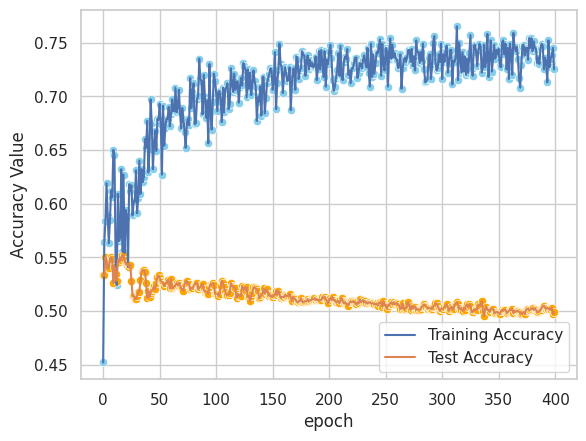

test
    TP   FN   FP  TN  accuracy  precision  recall  especificity        f1  \
0  309  191  401  99     0.408   0.435211   0.618         0.198  0.510744   

   auc_score  
0      0.408  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  383  117  384  116     0.499   0.499348   0.766         0.232  0.604578   

   auc_score  
0      0.499  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  398  102  141  359     0.757   0.738404   0.796         0.718  0.766121   

   auc_score  
0      0.757  


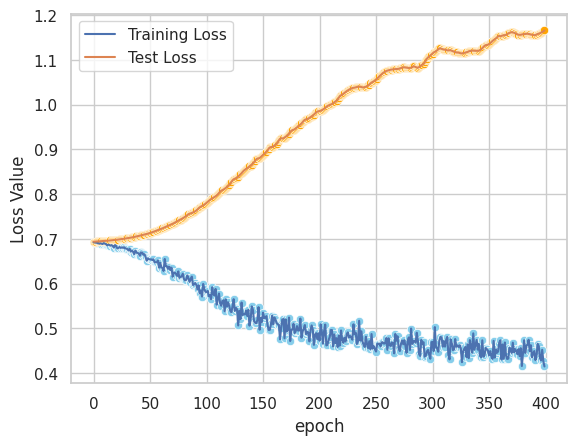

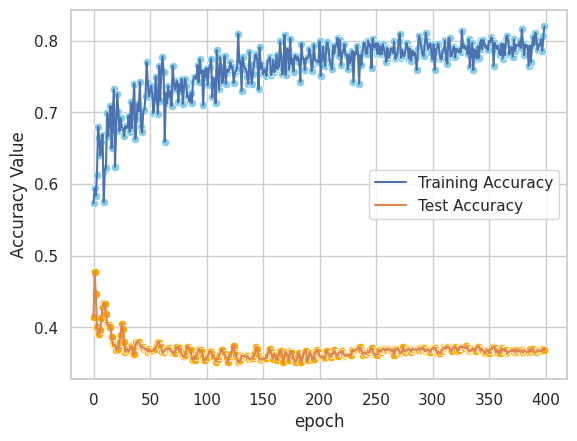

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  233  267  342  158     0.391   0.405217   0.466         0.316  0.433488   

   auc_score  
0      0.391  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  217  283  349  151     0.368   0.383392   0.434         0.302  0.407129   

   auc_score  
0      0.368  
train
    TP  FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  409  91  105  395     0.804    0.79572   0.818          0.79  0.806706   

   auc_score  
0      0.804  


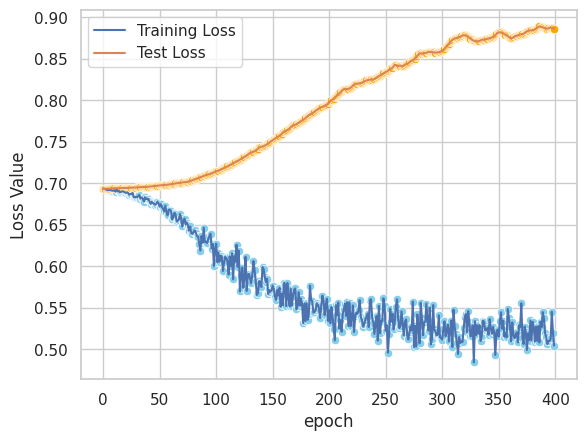

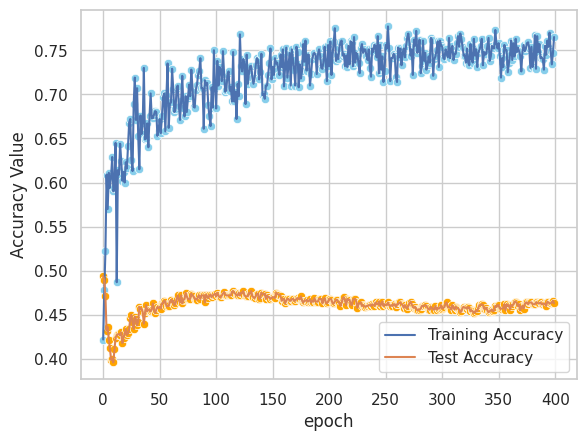

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  242  258  228  272     0.514   0.514894   0.484         0.544  0.498969   

   auc_score  
0      0.514  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity       f1  \
0  275  225  312  188     0.463   0.468484    0.55         0.376  0.50598   

   auc_score  
0      0.463  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  395  105  123  377     0.772   0.762548    0.79         0.754  0.776031   

   auc_score  
0      0.772  


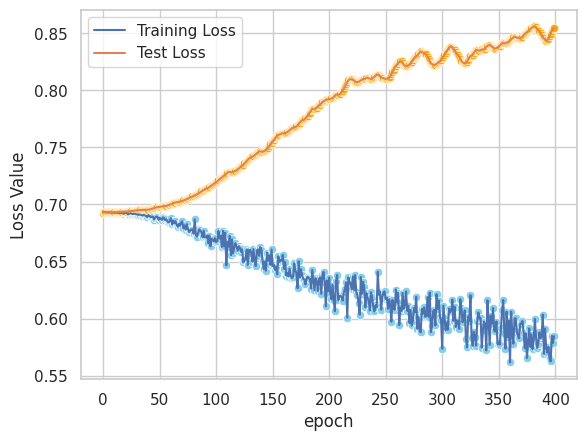

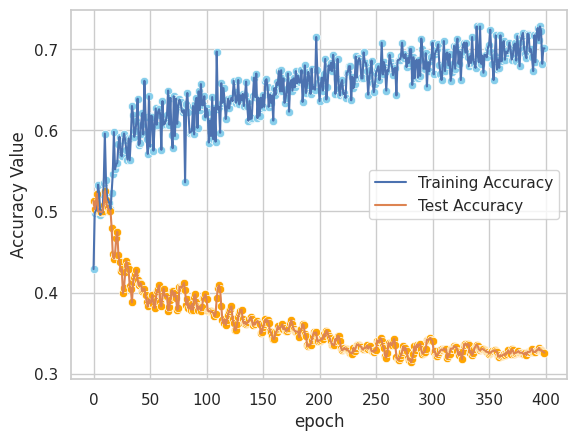

test
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  290  210  220  280      0.57   0.568627    0.58          0.56  0.574257   

   auc_score  
0       0.57  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  134  366  308  192     0.326   0.303167   0.268         0.384  0.284501   

   auc_score  
0      0.326  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  362  138  137  363     0.725   0.725451   0.724         0.726  0.724725   

   auc_score  
0      0.725  


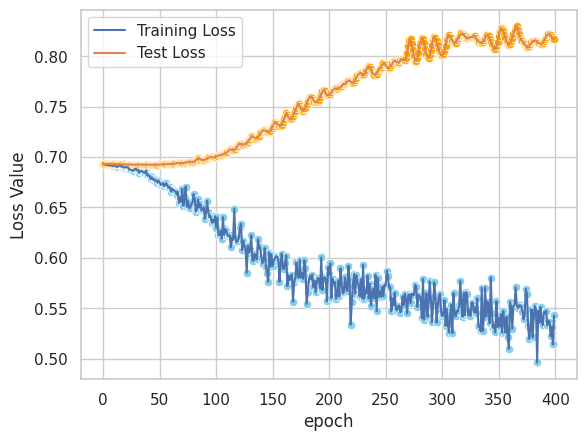

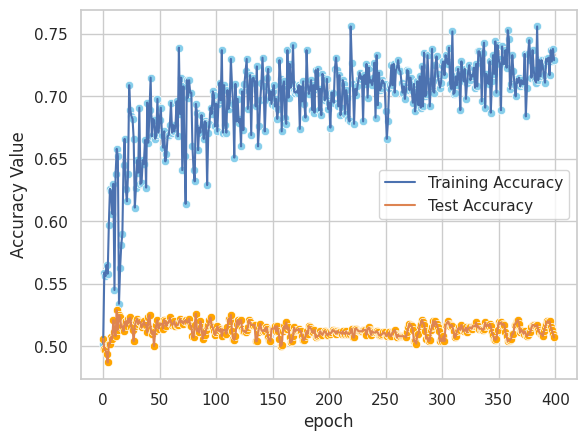

test
   TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  81  419  134  366     0.447   0.376744   0.162         0.732  0.226573   

   auc_score  
0      0.447  
val
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  157  343  150  350     0.507   0.511401   0.314           0.7  0.389095   

   auc_score  
0      0.507  
train
    TP   FN   FP   TN  accuracy  precision  recall  especificity        f1  \
0  358  142  122  378     0.736   0.745833   0.716         0.756  0.730612   

   auc_score  
0      0.736  


In [19]:
aux1 = train_and_test_carson(grafos1, 10)

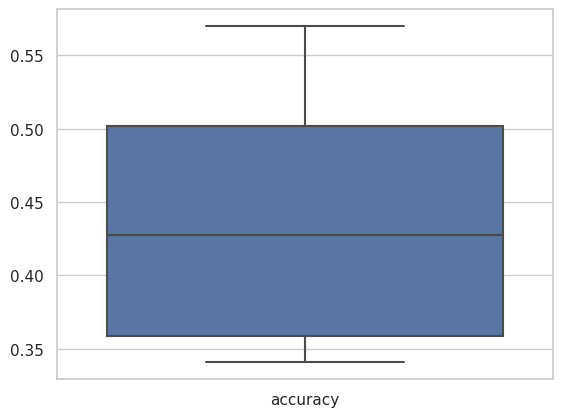

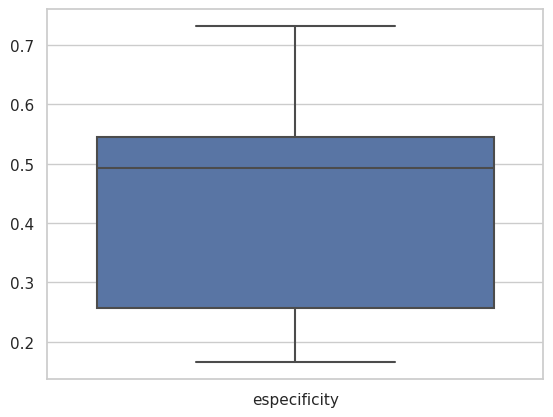

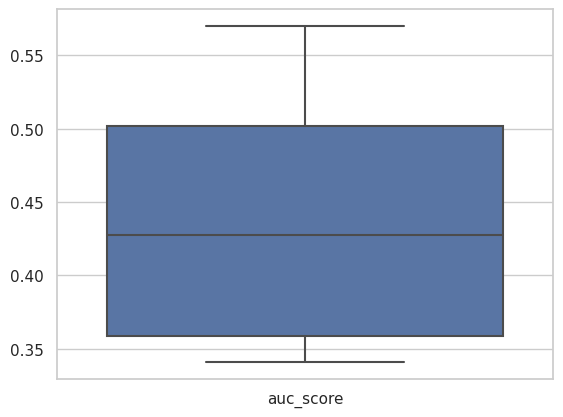

In [20]:
df1 = aux1[0]["test"]

for i in range(1,10):
    p = aux1[i]["test"]
    df1 = pd.concat([df1, p], ignore_index=True)
    
sns.set_theme(style="whitegrid")
boxplot1 = sns.boxplot(data=df1.iloc[:,4:5]) 
plt.show()
#plt.savefig(os.path.join(joinDirectorio,f'{str(NOMBRE_PRUEBA)}_especificity_{names[j]}.png'))                             
plt.clf()

sns.set_theme(style="whitegrid")
boxplot1 = sns.boxplot(data=df1.iloc[:,7:8]) 
plt.show()
#plt.savefig(os.path.join(joinDirectorio,f'{str(NOMBRE_PRUEBA)}_especificity_{names[j]}.png'))                             
plt.clf()
    
sns.set_theme(style="whitegrid")
boxplot2 = sns.boxplot(data=df1.iloc[:,9:10]) 
plt.show()
#plt.savefig(os.path.join(joinDirectorio,f'{str(NOMBRE_PRUEBA)}_auc_{names[j]}.png'))                             
plt.clf()